# Scoring Model
We decided that, for the purposes of this contest, scoring would be done as simply as possible. We have no values to evaluate against and only basic product information, so we are guessing based on assumptions about the target market.

In [6]:
import os

import pandas as pd
import us

os.chdir("/media/wkg/storage/mcbi-datapalooza-2019/data")

In [7]:
# Read in
zip_data = pd.read_csv("zip_data_final.csv", index_col=None)

# remove pesky "Unnamed" column
zip_data = zip_data.loc[:, ~zip_data.columns.str.contains('Unnamed')]

# Change zips to str and pad with 0s
zip_data["zip"] = zip_data["zip"].apply(lambda x: str(x).zfill(5))

We removed all zip codes with 0 population and all features that we deemed unnecessary for the scoring model.

In [8]:
# Remove zip codes with 0 population, these are not ideal to sell to
zip_data = zip_data[zip_data["population"] > 0]

# Remove US territories from data
states = us.states.STATES
states = [states[state].abbr for state in range(len(states))]
zip_data = zip_data[zip_data.state.isin(states)]

# Remove unneeded features
zip_data = pd.DataFrame(zip_data, columns=['zip', 'city', 'state', 'latitude', 
       'longitude', 'population', 'pop_45-49', 'pop_50-54', 'pop_55-59', 
       'pop_60-64', 'pop_65-69', 'pop_70-74', 'pop_75-inf', 
       'median_indiv_income', 'life_expectancy', 'rpp'])

# Create primary target population feature
zip_data['pop_45-54'] = zip_data['pop_45-49'] + zip_data['pop_50-54']

We decided to use a parabolic function to weight income. 

Our reasoning for this is:
* Low income individuals cannot afford the whole life insurance product
* High income individuals likely will have more than $25,000 in cash or liquid assets at time of death and have no need for this product

So, we want to penalize both high incomes and low incomes with a parabolic function:

$$score = \frac{-.0005(income(2 - \frac{rpp}{z}) - 40000) ^ 2 + 40000}{100}$$

Where rpp is the regional price parity for the zip code and z is the tuning value.

We also want to boost scores with higher target populations, but we do this additively because a population multiplier will result in very expensive, high population zip codes receiving maximum scores.

This gives us a final formula of:

$$score = \frac{-.0005(income(2 - \frac{rpp}{z}) - 40000) ^ 2 + 40000}{100} + booster\frac{target population}{max(target population)}$$

In [9]:
# This value is used to tune the RPP effect
rpp_tuning_val = 100

# The population booster boosts a zip codes score by its percentage of the max
pop_booster_val = 50

# The max value for the target population
max_target_pop = zip_data['pop_45-54'].max()

# Income weight
zip_data['score'] = -.0005 * (zip_data['median_indiv_income'] * (2 - zip_data['rpp'] / rpp_tuning_val) - 40000) ** 2 + 40000

# Divide by 100, to make the score nicer and to give the population booster more weight
zip_data['score'] = zip_data['score'] / 100

# Add population booster
zip_data['score'] = zip_data['score'] + pop_booster_val * zip_data['pop_50-54'] / max_target_pop

Our top ten zip codes after scoring are:

In [11]:
scores = pd.DataFrame(zip_data, columns=['zip', 'city', 'state', 'population', 'median_indiv_income', 'rpp', 'pop_45-54', 'score'])
scores.sort_values(by="score", ascending=False)[0:10]

,zip,city,state,population,median_indiv_income,rpp,pop_45-54,score
13438,30043,Lawrenceville,GA,88588.0,38131.0,96.3,14493.0,419.691950
34100,75052,Grand Prairie,TX,94133.0,40933.0,100.2,13964.0,417.050616
13520,30135,Douglasville,GA,65106.0,38876.0,96.3,10566.0,415.616737
13111,29483,Summerville,SC,77862.0,38229.0,96.2,10137.0,415.078662
13445,30052,Loganville,GA,63211.0,38910.0,96.3,9557.0,414.851402
3299,08527,Jackson,NJ,56139.0,51392.0,122.0,9548.0,413.926302
36760,80013,Aurora,CO,72650.0,41972.0,106.0,9969.0,413.785201
27824,60638,Chicago,IL,58990.0,41564.0,103.8,8157.0,412.728092
40738,92691,Mission Viejo,CA,50287.0,48829.0,117.7,8516.0,412.394486
41505,94538,Fremont,CA,67133.0,52131.0,124.7,9158.0,411.994874


Our top score belongs to a zip code in Lawrenceville, GA. This zip code seems like an ideal place to sell the whole life insurance product in question: it has a large target population, a reasonable median income, and a lower-than-average RPP.

It would be ideal to make the formula much more complex - we could also incorporate a sliding scale based on life expectancy to improve scores that have high 55-59 and 60-64 populations if the life expectancy is sufficiently high. However, when we have only a heuristic basis for evaluation, it seems foolish to introduce more variables that need to be tuned. Better yet, machine learning could be used to build a model to predict potential saleability for zip codes.

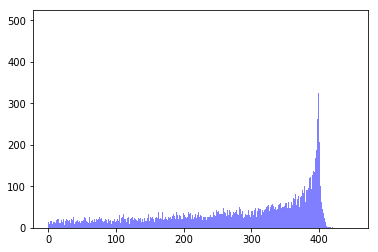

In [21]:
#########
# testing
#########
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 500
n, bins, patches = plt.hist(zip_data['score'], num_bins, range=[0,450], facecolor='blue', alpha=0.5)
plt.show()